In [1]:
import argparse
import logging
import math
import os
from functools import partial

from fvcore.common.checkpoint import PeriodicCheckpointer
import torch

from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data import collate_data_and_cast, DataAugmentationDINO, MaskingGenerator
import dinov2.distributed as distributed
from dinov2.fsdp import FSDPCheckpointer
from dinov2.logging import MetricLogger
from dinov2.utils.config import setup
from dinov2.utils.utils import CosineScheduler

from dinov2.train.ssl_meta_arch import SSLMetaArch

/traindata/maksim/repos/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/traindata/maksim/repos/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/traindata/maksim/repos/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
from argparse import Namespace
args = Namespace(config_file='dinov2/configs/train/vitl16_short.yaml', no_resume=False, eval_only=False, eval='', opts=['train.dataset_path=ImageNet:split=TRAIN:root=/traindata/maksim/datasets/imagenet/ILSVRC/Data/CLS-LOC:extra=/traindata/maksim/datasets/imagenet/ILSVRC/Data/CLS-LOC'], output_dir='out/dino1', ngpus=1, nodes=1, timeout=2800, partition='p5-ue2', use_volta32=False, comment='', exclude='')

In [3]:
cfg = setup(args)
cfg.student.arch = "vit_small"

[rank0]:[W416 22:37:34.411829939 ProcessGroupNCCL.cpp:4561] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. Specify device_ids in barrier() to force use of a particular device, or call init_process_group() with a device_id.


I20250416 22:37:36 1115334 dinov2 config.py:59] git:
  sha: e1277af2ba9496fbadf7aec6eba56e8d882d1e35, status: has uncommitted changes, branch: main

I20250416 22:37:36 1115334 dinov2 config.py:60] comment: 
config_file: dinov2/configs/train/vitl16_short.yaml
eval: 
eval_only: False
exclude: 
ngpus: 1
no_resume: False
nodes: 1
opts: ['train.dataset_path=ImageNet:split=TRAIN:root=/traindata/maksim/datasets/imagenet/ILSVRC/Data/CLS-LOC:extra=/traindata/maksim/datasets/imagenet/ILSVRC/Data/CLS-LOC', 'train.output_dir=/traindata/maksim/repos/dinov2/out/dino1']
output_dir: /traindata/maksim/repos/dinov2/out/dino1
partition: p5-ue2
timeout: 2800
use_volta32: False
I20250416 22:37:36 1115334 dinov2 config.py:26] sqrt scaling learning rate; base: 0.004, new: 0.001
I20250416 22:37:36 1115334 dinov2 config.py:33] MODEL:
  WEIGHTS: ''
compute_precision:
  grad_scaler: true
  teacher:
    backbone:
      sharding_strategy: SHARD_GRAD_OP
      mixed_precision:
        param_dtype: fp16
        reduc

In [4]:
model = SSLMetaArch(cfg).to(torch.device("cuda"))

I20250416 22:37:36 1115334 dinov2 vision_transformer.py:122] using MLP layer as FFN
I20250416 22:37:39 1115334 dinov2 vision_transformer.py:122] using MLP layer as FFN
I20250416 22:37:41 1115334 dinov2 ssl_meta_arch.py:43] OPTIONS -- architecture : embed_dim: 384
I20250416 22:37:41 1115334 dinov2 ssl_meta_arch.py:58] OPTIONS -- DINO
I20250416 22:37:41 1115334 dinov2 ssl_meta_arch.py:60] OPTIONS -- DINO -- loss_weight: 1.0
I20250416 22:37:41 1115334 dinov2 ssl_meta_arch.py:61] OPTIONS -- DINO -- head_n_prototypes: 65536
I20250416 22:37:41 1115334 dinov2 ssl_meta_arch.py:62] OPTIONS -- DINO -- head_bottleneck_dim: 256
I20250416 22:37:41 1115334 dinov2 ssl_meta_arch.py:63] OPTIONS -- DINO -- head_hidden_dim: 2048
I20250416 22:37:41 1115334 dinov2 ssl_meta_arch.py:75] OPTIONS -- DINO -- applying KOLEO regularization
W20250416 22:37:41 1115334 py.warnings warnings.py:110] /traindata/maksim/miniconda3/envs/dinov2/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: 

In [5]:
# Convert OmegaConf DictConfig to a regular Python dict
cfg

{'MODEL': {'WEIGHTS': ''}, 'compute_precision': {'grad_scaler': True, 'teacher': {'backbone': {'sharding_strategy': 'SHARD_GRAD_OP', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}, 'dino_head': {'sharding_strategy': 'SHARD_GRAD_OP', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}, 'ibot_head': {'sharding_strategy': 'SHARD_GRAD_OP', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}}, 'student': {'backbone': {'sharding_strategy': 'SHARD_GRAD_OP', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp16', 'buffer_dtype': 'fp32'}}, 'dino_head': {'sharding_strategy': 'SHARD_GRAD_OP', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp32', 'buffer_dtype': 'fp32'}}, 'ibot_head': {'sharding_strategy': 'SHARD_GRAD_OP', 'mixed_precision': {'param_dtype': 'fp16', 'reduce_dtype': 'fp32', 'buffer_dtype': 'fp32'}}}}, 'dino': {'loss_weight': 1.0, 'head_

In [6]:
# model.prepare_for_distributed_training()

In [7]:
data_transform = DataAugmentationDINO(
    cfg.crops.global_crops_scale,
    cfg.crops.local_crops_scale,
    cfg.crops.local_crops_number,
    global_crops_size=cfg.crops.global_crops_size,
    local_crops_size=cfg.crops.local_crops_size,
)

dataset = make_dataset(
    dataset_str=cfg.train.dataset_path,
    transform=data_transform,
    target_transform=lambda _: (),
)

I20250416 22:37:43 1115334 dinov2 augmentations.py:34] ###################################
I20250416 22:37:43 1115334 dinov2 augmentations.py:35] Using data augmentation parameters:
I20250416 22:37:43 1115334 dinov2 augmentations.py:36] global_crops_scale: [0.32, 1.0]
I20250416 22:37:43 1115334 dinov2 augmentations.py:37] local_crops_scale: [0.05, 0.32]
I20250416 22:37:43 1115334 dinov2 augmentations.py:38] local_crops_number: 8
I20250416 22:37:43 1115334 dinov2 augmentations.py:39] global_crops_size: 224
I20250416 22:37:43 1115334 dinov2 augmentations.py:40] local_crops_size: 96
I20250416 22:37:43 1115334 dinov2 augmentations.py:41] ###################################
I20250416 22:37:43 1115334 dinov2 loaders.py:84] using dataset: "ImageNet:split=TRAIN:root=/traindata/maksim/datasets/imagenet/ILSVRC/Data/CLS-LOC:extra=/traindata/maksim/datasets/imagenet/ILSVRC/Data/CLS-LOC"
I20250416 22:37:43 1115334 dinov2 loaders.py:89] # of dataset samples: 1,281,167


In [8]:
dataset[0]

({'global_crops': [tensor([[[ 1.3755,  1.3755,  1.3755,  ...,  1.3755,  1.3755,  1.3755],
            [ 1.3755,  1.3755,  1.3755,  ...,  1.3755,  1.3755,  1.3755],
            [ 1.3755,  1.3755,  1.3755,  ...,  1.3755,  1.3755,  1.3755],
            ...,
            [ 1.3755,  1.3755,  1.3755,  ..., -1.6213, -1.7583, -1.7583],
            [ 1.3755,  1.3755,  1.3755,  ..., -1.7583, -1.8268, -1.8439],
            [ 1.3755,  1.3755,  1.3755,  ..., -1.9124, -1.8953, -1.8610]],
   
           [[ 1.5357,  1.5357,  1.5357,  ...,  1.5357,  1.5357,  1.5357],
            [ 1.5357,  1.5357,  1.5357,  ...,  1.5357,  1.5357,  1.5357],
            [ 1.5357,  1.5357,  1.5357,  ...,  1.5357,  1.5357,  1.5357],
            ...,
            [ 1.5357,  1.5357,  1.5357,  ..., -1.7381, -1.8431, -1.9132],
            [ 1.5357,  1.5357,  1.5357,  ..., -1.8431, -1.9132, -1.9307],
            [ 1.5357,  1.5357,  1.5357,  ..., -2.0357, -1.9832, -1.9832]],
   
           [[ 1.7511,  1.7511,  1.7511,  ...,  1.751

In [9]:
img = dataset[0]
img[0]["global_crops"][0].shape, img[0]["global_crops"][1].shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [10]:
import matplotlib.pyplot as plt

def display_image(tensor_image):
    """
    Display an ImageNet image in torch.tensor format (3x224x224 size).
    
    Args:
        tensor_image (torch.Tensor): The image tensor to display.
    """
    tensor_image = tensor_image.to(torch.float32)
    # Convert the tensor to a numpy array and transpose the dimensions
    np_image = tensor_image.permute(1, 2, 0).cpu().numpy()
    
    # Normalize the image to the range [0, 1]
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()



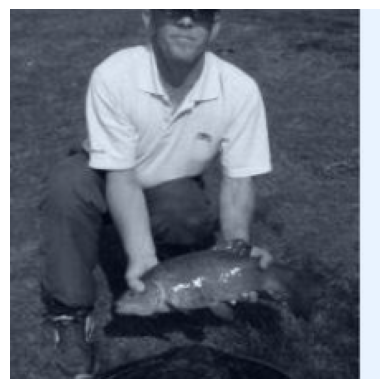

In [11]:
display_image(img[0]["global_crops"][0])

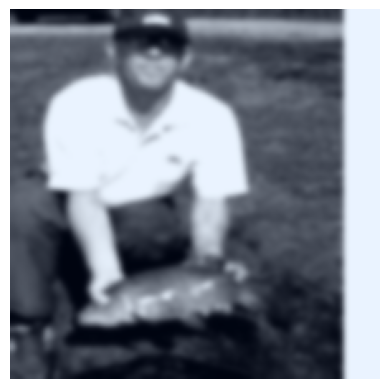

In [12]:
display_image(img[0]["global_crops"][1])

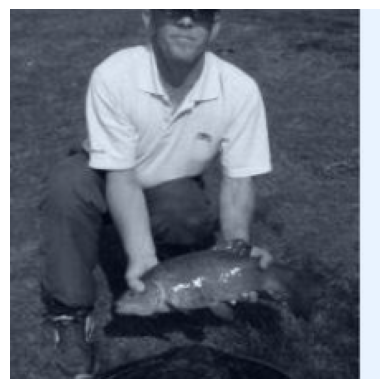

In [13]:
display_image(img[0]["global_crops_teacher"][0])

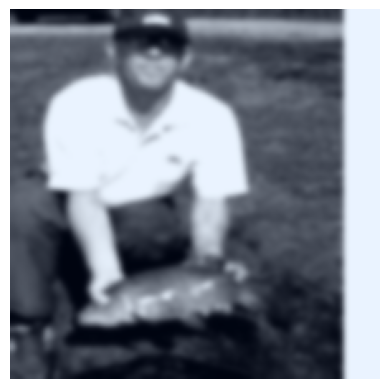

In [14]:
display_image(img[0]["global_crops_teacher"][1])

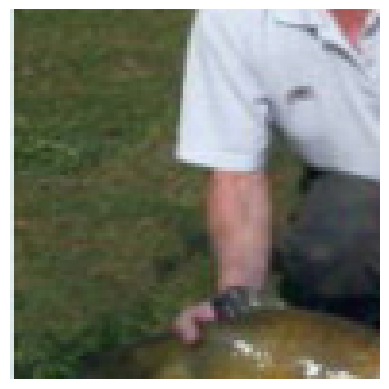

In [15]:
display_image(img[0]["local_crops"][0])

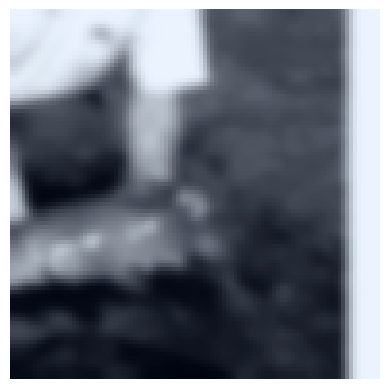

In [16]:
display_image(img[0]["local_crops"][1])

In [17]:
len(img[0]["global_crops_teacher"])

2

In [18]:
logger = logging.getLogger("dinov2")
def build_optimizer(cfg, params_groups):
    return torch.optim.AdamW(params_groups, betas=(cfg.optim.adamw_beta1, cfg.optim.adamw_beta2))


def build_schedulers(cfg):
    OFFICIAL_EPOCH_LENGTH = cfg.train.OFFICIAL_EPOCH_LENGTH
    lr = dict(
        base_value=cfg.optim["lr"],
        final_value=cfg.optim["min_lr"],
        total_iters=cfg.optim["epochs"] * OFFICIAL_EPOCH_LENGTH,
        warmup_iters=cfg.optim["warmup_epochs"] * OFFICIAL_EPOCH_LENGTH,
        start_warmup_value=0,
    )
    wd = dict(
        base_value=cfg.optim["weight_decay"],
        final_value=cfg.optim["weight_decay_end"],
        total_iters=cfg.optim["epochs"] * OFFICIAL_EPOCH_LENGTH,
    )
    momentum = dict(
        base_value=cfg.teacher["momentum_teacher"],
        final_value=cfg.teacher["final_momentum_teacher"],
        total_iters=cfg.optim["epochs"] * OFFICIAL_EPOCH_LENGTH,
    )
    teacher_temp = dict(
        base_value=cfg.teacher["teacher_temp"],
        final_value=cfg.teacher["teacher_temp"],
        total_iters=cfg.teacher["warmup_teacher_temp_epochs"] * OFFICIAL_EPOCH_LENGTH,
        warmup_iters=cfg.teacher["warmup_teacher_temp_epochs"] * OFFICIAL_EPOCH_LENGTH,
        start_warmup_value=cfg.teacher["warmup_teacher_temp"],
    )

    lr_schedule = CosineScheduler(**lr)
    wd_schedule = CosineScheduler(**wd)
    momentum_schedule = CosineScheduler(**momentum)
    teacher_temp_schedule = CosineScheduler(**teacher_temp)
    last_layer_lr_schedule = CosineScheduler(**lr)

    last_layer_lr_schedule.schedule[
        : cfg.optim["freeze_last_layer_epochs"] * OFFICIAL_EPOCH_LENGTH
    ] = 0  # mimicking the original schedules

    logger.info("Schedulers ready.")

    return (
        lr_schedule,
        wd_schedule,
        momentum_schedule,
        teacher_temp_schedule,
        last_layer_lr_schedule,
    )

In [19]:
cfg.train.batch_size_per_gpu

64

In [20]:
resume = False
inputs_dtype = torch.half

optimizer = build_optimizer(cfg, model.get_params_groups())
(
    lr_schedule,
    wd_schedule,
    momentum_schedule,
    teacher_temp_schedule,
    last_layer_lr_schedule,
) = build_schedulers(cfg)
checkpointer = FSDPCheckpointer(model, cfg.train.output_dir, optimizer=optimizer, save_to_disk=True)
#start_iter = checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
img_size = cfg.crops.global_crops_size
patch_size = cfg.student.patch_size
n_tokens = (img_size // patch_size) ** 2

mask_generator = MaskingGenerator(
        input_size=(img_size // patch_size, img_size // patch_size),
        max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
    )

collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=cfg.ibot.mask_ratio_min_max,
    mask_probability=cfg.ibot.mask_sample_probability,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
)
sampler_type = SamplerType.SHARDED_INFINITE
data_loader = make_data_loader(
    dataset=dataset,
    batch_size=1,
    num_workers=cfg.train.num_workers,
    shuffle=True,
    seed=42,  # TODO: Fix this -- cfg.train.seed
    sampler_type=sampler_type,
    sampler_advance=0,  # TODO(qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
    drop_last=True,
    collate_fn=collate_fn,
)

I20250416 22:37:45 1115334 dinov2 param_groups.py:54] chunked fsdp
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] cls_token: lr_multiplier: 0.2541865828329001, wd_multiplier: 1.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] pos_embed: lr_multiplier: 0.2541865828329001, wd_multiplier: 1.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] mask_token: lr_multiplier: 0.2541865828329001, wd_multiplier: 1.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] patch_embed.proj.weight: lr_multiplier: 0.05083731656658002, wd_multiplier: 1.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] patch_embed.proj.bias: lr_multiplier: 0.05083731656658002, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.0.norm1.weight: lr_multiplier: 0.2824295364810001, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.0.norm1.bias: lr_multiplier: 0.2824295364810001, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_group

I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.1.norm2.weight: lr_multiplier: 0.31381059609000006, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.1.norm2.bias: lr_multiplier: 0.31381059609000006, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.1.mlp.fc1.weight: lr_multiplier: 0.31381059609000006, wd_multiplier: 1.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.1.mlp.fc1.bias: lr_multiplier: 0.31381059609000006, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.1.mlp.fc2.weight: lr_multiplier: 0.31381059609000006, wd_multiplier: 1.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.1.mlp.fc2.bias: lr_multiplier: 0.31381059609000006, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.1.ls2.gamma: lr_multiplier: 0.31381059609000006, wd_multiplier: 0.0
I20250416 22:37:45 1115334 dinov2 param_groups.py:87] blocks.0.

In [21]:
for batch in data_loader:
    break
batch

{'collated_global_crops': tensor([[[[ 1.4268,  1.3926,  1.3760,  ...,  0.3994,  0.4851,  0.4851],
           [ 1.3760,  1.4443,  1.5127,  ...,  0.5195,  0.5195,  0.4680],
           [ 1.4443,  1.4609,  1.4268,  ...,  0.4165,  0.4680,  0.4680],
           ...,
           [-1.2959, -1.2100, -1.2275,  ..., -1.2100, -1.2617, -1.3477],
           [-1.2783, -1.2783, -1.3301,  ..., -1.2783, -1.3301, -1.2441],
           [-1.3643, -1.2783, -1.3135,  ..., -1.2783, -1.2959, -1.2783]],
 
          [[ 1.5879,  1.5527,  1.5703,  ...,  0.3103,  0.3977,  0.3276],
           [ 1.5527,  1.6406,  1.6934,  ...,  0.3977,  0.3977,  0.3276],
           [ 1.6230,  1.6406,  1.6055,  ...,  0.2578,  0.3103,  0.3276],
           ...,
           [-1.1953, -1.1074, -1.1250,  ..., -1.0029, -1.0732, -1.2129],
           [-1.1074, -1.1777, -1.2305,  ..., -1.1074, -1.1250, -1.1074],
           [-1.2129, -1.1777, -1.2129,  ..., -1.1074, -1.1074, -1.1426]],
 
          [[ 1.9082,  1.8555,  1.8379,  ...,  0.3743,  0.4788

In [22]:
batch.keys()

dict_keys(['collated_global_crops', 'collated_local_crops', 'collated_masks', 'mask_indices_list', 'masks_weight', 'upperbound', 'n_masked_patches'])

In [23]:
batch["collated_global_crops"] = batch["collated_global_crops"].float()
batch["collated_local_crops"] = batch["collated_local_crops"].float()

In [24]:
batch["collated_local_crops"].shape

torch.Size([8, 3, 96, 96])

In [26]:
#batch = {k: v.to(torch.device("cuda")) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
loss = model.forward_backward(batch, teacher_temp=0.07)
loss

W20250416 22:38:14 1115334 py.warnings warnings.py:110] /traindata/maksim/repos/dinov2/dinov2/loss/koleo_loss.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



{'dino_local_crops_loss': tensor(10.0294, device='cuda:0', grad_fn=<DivBackward0>),
 'dino_global_crops_loss': tensor(1.2537, device='cuda:0', grad_fn=<DivBackward0>),
 'koleo_loss': tensor(1.5396, device='cuda:0', grad_fn=<DivBackward0>),
 'ibot_loss': tensor(2.8213, device='cuda:0', grad_fn=<DivBackward0>)}